In [1]:
import os
import json
import numpy as np
import torch.nn.functional as F

import torch
import torch.nn as nn
from torch.optim import AdamW
import cv2
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
# from torchvision.models import resnet18
from torchvision.models import resnet50
from torchvision.models import efficientnet_b2
from torchvision.models import convnext_tiny
import torch.nn.functional as F

# % pip install timm
# import timm
# from timm.data import resolve_data_config
# from timm.data.transforms_factory import create_transform

import torchvision
from torchvision.transforms import transforms
from torchvision.transforms import ToTensor, Lambda
import torch.nn.functional as F
from torch.autograd import Variable
from glob import glob
import shutil
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import classification_report

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! unzip ./drive/MyDrive/소재.zip -d ./zip_data


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: ./zip_data/pic_filter/359560.jpg  
  inflating: ./zip_data/pic_filter/359570.jpg  
  inflating: ./zip_data/pic_filter/359730.jpg  
  inflating: ./zip_data/pic_filter/359760.jpg  
  inflating: ./zip_data/pic_filter/360201.jpg  
  inflating: ./zip_data/pic_filter/360230.jpg  
  inflating: ./zip_data/pic_filter/360290.jpg  
  inflating: ./zip_data/pic_filter/360440.jpg  
  inflating: ./zip_data/pic_filter/360480.jpg  
  inflating: ./zip_data/pic_filter/360620.jpg  
  inflating: ./zip_data/pic_filter/360670.jpg  
  inflating: ./zip_data/pic_filter/360780.jpg  
  inflating: ./zip_data/pic_filter/360880.jpg  
  inflating: ./zip_data/pic_filter/360901.jpg  
  inflating: ./zip_data/pic_filter/360970.jpg  
  inflating: ./zip_data/pic_filter/360990.jpg  
  inflating: ./zip_data/pic_filter/361020.jpg  
  inflating: ./zip_data/pic_filter/361030.jpg  
  inflating: ./zip_data/pic_filter/361040.jpg  
  inflating: ./zip_data/pic_filter/361080.jpg  
  in

In [4]:
zip_dir = "./zip_data"
save_dir = "./drive/MyDrive/laundry_step_ckpoint"

json_dir = "./zip_data/json_filter"
image_dir = "./zip_data/pic_filter"

json_files = []
image_files = []

for train_file in os.listdir(json_dir):
    json_files.append(os.path.join(json_dir, train_file))
    image_files.append(os.path.splitext(train_file)[0])

print("데이터 개수:", len(json_files))
print("이미지 개수:", len(image_files))
# print("json 장르", json_genre)
# print("image 장르", image_genre)

데이터 개수: 18003
이미지 개수: 18003


In [5]:
train_image, val_image, train_json, val_json = train_test_split(image_files, json_files, test_size=0.2, random_state=42, shuffle=True)
print(len(train_image), len(val_image))
print(len(train_json), len(val_json))

14402 3601
14402 3601


In [6]:
clothes_class = ["아우터", "하의", "원피스", "상의"]
clothes_xy = {"outer_xy":None, "pants_xy":None, "onepiece_xy":None, "shirt_xy":None}
clothes_fabric = {"outer_fabric":None, "pants_fabric":None, "onepiece_fabric":None, "shirt_fabric":None}

train_image_dict = {}
valid_image_dict = {}

for file in tqdm(train_json):
    if os.path.splitext(file.split("/")[-1])[0] not in train_image: #이미지 파일 없을 때
        continue
    with open(file, "rb") as f:
        data = json.load(f)
        file_id = data['이미지 정보']['이미지 식별자']
        file_name=str(data['이미지 정보']['이미지 식별자'])+'.jpg'
        for cls, xy, fabric in zip(clothes_class, clothes_xy, clothes_fabric):
            clothes_xy[xy] = data['데이터셋 정보']['데이터셋 상세설명']['렉트좌표'][cls][0].values()
            if not clothes_xy[xy]:
                continue

            try:
                clothes_fabric[fabric] = data['데이터셋 정보']['데이터셋 상세설명']['라벨링'][cls][0]['소재']
            except:
                pass

    for xy, fabric in zip(clothes_xy.values(), clothes_fabric.values()):
        if not xy:
            continue
        if list(xy)[2] < 1 or list(xy)[3] < 1:
            continue
        train_image_dict[(file_name, xy)] = fabric        

for file in tqdm(val_json):
    if os.path.splitext(file.split("/")[-1])[0] not in val_image: #이미지 파일 없을 때
        continue
    with open(file, "rb") as f:
        data = json.load(f)
        file_name = str(data['이미지 정보']['이미지 식별자'])+'.jpg'
        for cls, xy, fabric in zip(clothes_class, clothes_xy, clothes_fabric):
            clothes_xy[xy] = data['데이터셋 정보']['데이터셋 상세설명']['렉트좌표'][cls][0].values()
            if not clothes_xy[xy]:
                continue
            try:
                clothes_fabric[fabric] = data['데이터셋 정보']['데이터셋 상세설명']['라벨링'][cls][0]['소재']
            except:
                pass    

    for xy, fabric in zip(clothes_xy.values(), clothes_fabric.values()):
        if not xy:
            continue
        if list(xy)[2] < 1 or list(xy)[3] < 1:
            continue        
        valid_image_dict[(file_name, xy)] = fabric     
        


100%|██████████| 3601/3601 [00:00<00:00, 7278.51it/s]


In [7]:
#사용자 정의 데이터셋
class ClothDataset(Dataset):
    def __init__(self, train_image_dict, transform=None, data_dir=r"./zip_data/pic_filter"): 
        super().__init__()
        self.data_dir = data_dir
        self.train_image_dict = train_image_dict
        self.transform = transform
        self.image_files = []
        self.dict_label_to_num = {
            "메시": 0,"데님" : 0 , "우븐": 0 ,"패딩" : 0,
            "니트":1,"레이스":1,"린넨":1,"플리스":1,"네오프렌":1, "저지":1,"울/캐시미어" :1,"헤어 니트": 1,
            "퍼":2,"코듀로이":2,"실크":2,"스판덱스":2,"트위드":2,"자카드":2 ,"벨벳":2,"시폰":2,
            "스웨이드":3,"시퀸/글리터":3,"가죽":3,"비닐/PVC":3
          
        } #0:물세탁, 1:울세탁, 2:드라이클리닝, 3:기타
        self.setup()

    def setup(self):
        for (file_name, xy), fabric in self.train_image_dict.items():
            if not fabric:
                continue
            self.image_files.append((os.path.join(self.data_dir, file_name), xy, fabric))

    def __getitem__(self, idx):
        file_name, xy, fabric = self.image_files[idx]
        fabric=fabric[0]
        x, y, w, h = map(int, xy)
        im = Image.open(file_name)
        im = transforms.ToTensor()(im)
        im = torchvision.transforms.functional.crop(im, y, x, h, w)
        im = transforms.Resize((224,224))(im) #,Image.BILINEAR      
        if self.transform:
            im = self.transform(im)
        fabric_label = self.dict_label_to_num[fabric] 
        
        return im, fabric_label
    
    def __len__(self):
        return len(self.image_files)




In [8]:
train_dataset = ClothDataset(train_image_dict)
valid_dataset = ClothDataset(valid_image_dict)
print(len(train_dataset))
print(len(valid_dataset))


22426
5622


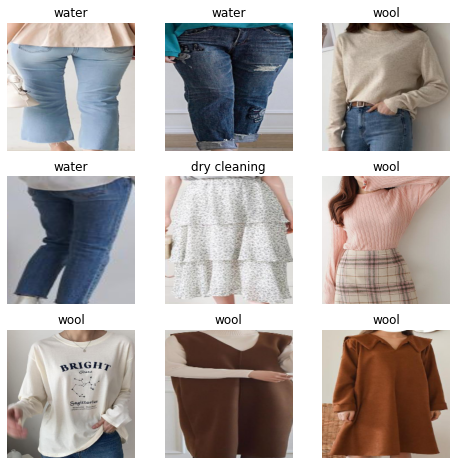

In [9]:
classes=["water",
        "wool",
        "dry cleaning",
        "etc"] 

figure = plt.figure(figsize=(8,8))
cols, rows= 3,3

for i in range(1, cols*rows+1):
    sample_idx=torch.randint(len(train_dataset),size=(1,)).item()    
    img, label= train_dataset[sample_idx]   

    figure.add_subplot(rows, cols, i)
    title=classes[label]
    plt.title(title)
    plt.axis("off")
    plt.imshow(img.permute(1,2,0))
plt.show()

In [ ]:
class efficientnet_b2(nn.Module): 
    def __init__(self, num_classes):
        super().__init__()
        self.model = torchvision.models.efficientnet_b2(pretrained=True)
        self.fc = nn.Linear(1000, num_classes) 
        
    def forward(self, x):
        x = self.model(x)
        return self.fc(x)


In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int)): self.alpha = torch.Tensor([alpha,1-alpha]) #,long
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()

In [ ]:
BATCH_SIZE = 64 #32
EPOCHS =10
LOG_INTERVAL=35 #35
LEARNING_RATE=0.001 #0.001

torch.cuda.empty_cache()
device=torch.device("cuda") 

train_loader=DataLoader(train_dataset, batch_size=BATCH_SIZE, drop_last=True,shuffle=True)
valid_loader=DataLoader(valid_dataset, batch_size=BATCH_SIZE, drop_last=True,shuffle=True)

model = efficientnet_b2(num_classes=4).cuda() #gpu
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.95) #1e-5
scheduler = StepLR(optimizer, step_size=1, gamma=0.2) #0.5
best_val_acc = 0
best_val_loss = np.inf

for epoch in range(EPOCHS):
    model.train()
    loss_value=0
    matches=0
    for idx, batch in enumerate(tqdm(train_loader)): #train_loader
        inputs, labels=batch
        
        inputs=inputs.to(device)
        labels=labels.to(device)
        
        optimizer.zero_grad()
        outs=model(inputs)
                
        preds=torch.argmax(outs,dim=-1)    
        num_label=labels.tolist()     #😊
        num_pred=preds.tolist() 
       
        loss = FocalLoss(gamma=1)(outs,labels) 
        loss.backward()
        optimizer.step()

        loss_value += loss.item()
        matches += (preds==labels).sum().item()
        if(idx+1) % LOG_INTERVAL==0:
            train_loss=loss_value / LOG_INTERVAL
            train_acc=matches / BATCH_SIZE / LOG_INTERVAL
            print(
                f"Epoch[{epoch}/{EPOCHS}]({idx + 1}/{len(train_loader)}) || " #train_loader
                f"training loss {train_loss:4.4} || training accuracy {train_acc:4.2%}"
            )
            torch.save(model.state_dict(), f"{save_dir}/{idx}.pth")
            loss_value = 0
            matches = 0
    scheduler.step()
    

    with torch.no_grad():
        print("Calculating validation results...")
        model.eval() 
        val_loss_items=[]
        val_acc_items=[]
        total_label=[]
        total_pred=[]

        for val_batch in tqdm(valid_loader):
            inputs, labels=val_batch
            inputs=inputs.to(device)
            labels=labels.to(device)

            outs=model(inputs)
            preds=torch.argmax(outs, dim=-1)

            num_label=labels.tolist()     #😊
            num_pred=preds.tolist() 
            total_label.extend(num_label)
            total_pred.extend(num_pred)


            loss_item = FocalLoss(gamma=1)(outs,labels).item()                       
            acc_item = (labels == preds).sum().item()
            
            val_loss_items.append(loss_item)
            val_acc_items.append(acc_item)

        val_loss= np.sum(val_loss_items) / len(valid_loader)
        val_acc = np.sum(val_acc_items) / len(valid_dataset)
        # val_acc = np.sum(val_acc_items) / len(new_valid_dataset)
        best_val_loss = min(best_val_loss, val_loss) #검증용 데이터를 모델에 넣어 loss(MSE(used 손실함수))를 확인해 트레이닝이 잘 되고 있는지 확인(모델 사용)        
        print(classification_report(total_label, total_pred, target_names=['class 0', 'class 1', 'class 2','class 3']))

        if val_acc > best_val_acc:
            print(f"New best model for val accuracy : {val_acc:4.2%}! saving the best model..")
            torch.save(model.state_dict(), f"{save_dir}/best.pth")
            best_val_acc = val_acc
        
        torch.save(model.state_dict(),f"{save_dir}/last.pth")
        print(
            f"[Val] acc : {val_acc:4.2%}, loss: {val_loss:4.2} || "
            f"best acc : {best_val_acc:4.2%}, best loss: {best_val_loss:4.2}"
        )
                  
    

 10%|█         | 35/350 [00:51<07:54,  1.51s/it]

Epoch[0/10](35/350) || training loss 0.7582 || training accuracy 56.12%


 20%|██        | 70/350 [01:41<07:18,  1.57s/it]

Epoch[0/10](70/350) || training loss 0.5826 || training accuracy 60.80%


 30%|███       | 105/350 [02:32<06:08,  1.50s/it]

Epoch[0/10](105/350) || training loss 0.5693 || training accuracy 62.95%


 40%|████      | 140/350 [03:23<05:14,  1.50s/it]

Epoch[0/10](140/350) || training loss 0.5539 || training accuracy 63.88%


 50%|█████     | 175/350 [04:14<04:23,  1.51s/it]

Epoch[0/10](175/350) || training loss 0.5152 || training accuracy 67.23%


 60%|██████    | 210/350 [05:05<03:28,  1.49s/it]

Epoch[0/10](210/350) || training loss 0.5388 || training accuracy 66.74%


 70%|███████   | 245/350 [05:57<02:42,  1.55s/it]

Epoch[0/10](245/350) || training loss 0.5185 || training accuracy 67.10%


 80%|████████  | 280/350 [06:50<01:49,  1.56s/it]

Epoch[0/10](280/350) || training loss 0.5224 || training accuracy 67.86%


 90%|█████████ | 315/350 [07:42<00:53,  1.53s/it]

Epoch[0/10](315/350) || training loss 0.5244 || training accuracy 67.59%


100%|██████████| 350/350 [08:37<00:00,  1.48s/it]


Epoch[0/10](350/350) || training loss 0.4834 || training accuracy 69.82%
Calculating validation results...


100%|██████████| 88/88 [01:36<00:00,  1.10s/it]


              precision    recall  f1-score   support

     class 0       0.67      0.69      0.68      2043
     class 1       0.70      0.79      0.74      2452
     class 2       0.67      0.45      0.54      1068
     class 3       0.60      0.04      0.08        69

    accuracy                           0.68      5632
   macro avg       0.66      0.49      0.51      5632
weighted avg       0.68      0.68      0.67      5632

New best model for val accuracy : 68.15%! saving the best model..
[Val] acc : 68.15%, loss: 0.52 || best acc : 68.15%, best loss: 0.52


 10%|█         | 35/350 [00:52<08:02,  1.53s/it]

Epoch[1/10](35/350) || training loss 0.4499 || training accuracy 72.37%


 20%|██        | 70/350 [01:43<07:07,  1.53s/it]

Epoch[1/10](70/350) || training loss 0.4426 || training accuracy 71.83%


 30%|███       | 105/350 [02:35<06:15,  1.53s/it]

Epoch[1/10](105/350) || training loss 0.4055 || training accuracy 74.69%


 40%|████      | 140/350 [03:26<05:17,  1.51s/it]

Epoch[1/10](140/350) || training loss 0.407 || training accuracy 74.46%


 50%|█████     | 175/350 [04:18<04:21,  1.49s/it]

Epoch[1/10](175/350) || training loss 0.3979 || training accuracy 74.02%


 60%|██████    | 210/350 [05:08<03:28,  1.49s/it]

Epoch[1/10](210/350) || training loss 0.407 || training accuracy 73.93%


 70%|███████   | 245/350 [06:00<02:36,  1.49s/it]

Epoch[1/10](245/350) || training loss 0.396 || training accuracy 76.25%


 80%|████████  | 280/350 [06:50<01:44,  1.49s/it]

Epoch[1/10](280/350) || training loss 0.3955 || training accuracy 74.73%


 90%|█████████ | 315/350 [07:41<00:51,  1.49s/it]

Epoch[1/10](315/350) || training loss 0.4049 || training accuracy 74.06%


100%|██████████| 350/350 [08:31<00:00,  1.46s/it]


Epoch[1/10](350/350) || training loss 0.391 || training accuracy 74.11%
Calculating validation results...


100%|██████████| 88/88 [01:33<00:00,  1.06s/it]


              precision    recall  f1-score   support

     class 0       0.75      0.69      0.72      2042
     class 1       0.71      0.83      0.77      2453
     class 2       0.73      0.60      0.66      1068
     class 3       0.89      0.25      0.39        69

    accuracy                           0.73      5632
   macro avg       0.77      0.59      0.63      5632
weighted avg       0.73      0.73      0.72      5632

New best model for val accuracy : 72.87%! saving the best model..
[Val] acc : 72.87%, loss: 0.43 || best acc : 72.87%, best loss: 0.43


 10%|█         | 35/350 [00:53<07:46,  1.48s/it]

Epoch[2/10](35/350) || training loss 0.3479 || training accuracy 76.88%


 20%|██        | 70/350 [01:43<06:59,  1.50s/it]

Epoch[2/10](70/350) || training loss 0.3247 || training accuracy 79.51%


 30%|███       | 105/350 [02:35<06:03,  1.48s/it]

Epoch[2/10](105/350) || training loss 0.3219 || training accuracy 79.33%


 40%|████      | 140/350 [03:25<05:16,  1.51s/it]

Epoch[2/10](140/350) || training loss 0.3279 || training accuracy 78.08%


 50%|█████     | 175/350 [04:16<04:22,  1.50s/it]

Epoch[2/10](175/350) || training loss 0.3209 || training accuracy 79.29%


 60%|██████    | 210/350 [05:07<03:30,  1.50s/it]

Epoch[2/10](210/350) || training loss 0.3018 || training accuracy 80.31%


 70%|███████   | 245/350 [05:59<02:51,  1.63s/it]

Epoch[2/10](245/350) || training loss 0.3104 || training accuracy 80.49%


 80%|███████▉  | 279/350 [06:50<01:40,  1.42s/it]

Epoch[2/10](280/350) || training loss 0.3202 || training accuracy 78.04%


 90%|█████████ | 315/350 [07:42<00:51,  1.48s/it]

Epoch[2/10](315/350) || training loss 0.3011 || training accuracy 79.46%


100%|██████████| 350/350 [08:34<00:00,  1.47s/it]


Epoch[2/10](350/350) || training loss 0.2982 || training accuracy 79.69%
Calculating validation results...


100%|██████████| 88/88 [01:31<00:00,  1.04s/it]


              precision    recall  f1-score   support

     class 0       0.77      0.69      0.73      2042
     class 1       0.74      0.82      0.78      2453
     class 2       0.70      0.67      0.68      1068
     class 3       0.53      0.39      0.45        69

    accuracy                           0.74      5632
   macro avg       0.69      0.64      0.66      5632
weighted avg       0.74      0.74      0.74      5632

New best model for val accuracy : 74.13%! saving the best model..
[Val] acc : 74.13%, loss: 0.42 || best acc : 74.13%, best loss: 0.42


 10%|█         | 35/350 [00:50<07:50,  1.49s/it]

Epoch[3/10](35/350) || training loss 0.2593 || training accuracy 83.26%


 20%|██        | 70/350 [01:40<06:56,  1.49s/it]

Epoch[3/10](70/350) || training loss 0.2587 || training accuracy 82.63%


 30%|██▉       | 104/350 [02:28<05:52,  1.43s/it]

Epoch[3/10](105/350) || training loss 0.2792 || training accuracy 82.10%


 40%|████      | 140/350 [03:20<05:13,  1.49s/it]

Epoch[3/10](140/350) || training loss 0.2654 || training accuracy 81.52%


 50%|█████     | 175/350 [04:11<04:19,  1.48s/it]

Epoch[3/10](175/350) || training loss 0.2721 || training accuracy 81.92%


 60%|██████    | 210/350 [05:01<03:26,  1.48s/it]

Epoch[3/10](210/350) || training loss 0.2867 || training accuracy 80.71%


 70%|███████   | 245/350 [05:51<02:33,  1.47s/it]

Epoch[3/10](245/350) || training loss 0.2856 || training accuracy 80.85%


 80%|████████  | 280/350 [06:41<01:41,  1.45s/it]

Epoch[3/10](280/350) || training loss 0.273 || training accuracy 81.83%


 90%|█████████ | 315/350 [07:31<00:51,  1.48s/it]

Epoch[3/10](315/350) || training loss 0.2818 || training accuracy 80.67%


100%|██████████| 350/350 [08:21<00:00,  1.43s/it]


Epoch[3/10](350/350) || training loss 0.2585 || training accuracy 83.48%
Calculating validation results...


100%|██████████| 88/88 [01:31<00:00,  1.04s/it]


              precision    recall  f1-score   support

     class 0       0.77      0.69      0.73      2043
     class 1       0.74      0.82      0.78      2452
     class 2       0.69      0.69      0.69      1068
     class 3       0.64      0.39      0.49        69

    accuracy                           0.74      5632
   macro avg       0.71      0.65      0.67      5632
weighted avg       0.74      0.74      0.74      5632

[Val] acc : 74.13%, loss: 0.42 || best acc : 74.13%, best loss: 0.42


 10%|█         | 35/350 [00:49<07:43,  1.47s/it]

Epoch[4/10](35/350) || training loss 0.2538 || training accuracy 82.99%


 20%|██        | 70/350 [01:40<07:00,  1.50s/it]

Epoch[4/10](70/350) || training loss 0.265 || training accuracy 82.05%


 30%|███       | 105/350 [02:29<06:00,  1.47s/it]

Epoch[4/10](105/350) || training loss 0.2493 || training accuracy 83.48%


 40%|████      | 140/350 [03:19<05:07,  1.47s/it]

Epoch[4/10](140/350) || training loss 0.2627 || training accuracy 82.28%


 50%|█████     | 175/350 [04:09<04:14,  1.45s/it]

Epoch[4/10](175/350) || training loss 0.2776 || training accuracy 81.34%


 60%|██████    | 210/350 [04:58<03:26,  1.48s/it]

Epoch[4/10](210/350) || training loss 0.2611 || training accuracy 82.14%


 70%|███████   | 245/350 [05:48<02:35,  1.48s/it]

Epoch[4/10](245/350) || training loss 0.2728 || training accuracy 81.83%


 80%|████████  | 280/350 [06:38<01:41,  1.46s/it]

Epoch[4/10](280/350) || training loss 0.251 || training accuracy 83.44%


 90%|█████████ | 315/350 [07:28<00:51,  1.47s/it]

Epoch[4/10](315/350) || training loss 0.2499 || training accuracy 83.26%


100%|██████████| 350/350 [08:18<00:00,  1.42s/it]


Epoch[4/10](350/350) || training loss 0.2631 || training accuracy 81.70%
Calculating validation results...


100%|██████████| 88/88 [01:31<00:00,  1.04s/it]


              precision    recall  f1-score   support

     class 0       0.76      0.70      0.73      2042
     class 1       0.74      0.82      0.78      2453
     class 2       0.70      0.67      0.69      1068
     class 3       0.62      0.41      0.49        69

    accuracy                           0.74      5632
   macro avg       0.71      0.65      0.67      5632
weighted avg       0.74      0.74      0.74      5632

New best model for val accuracy : 74.15%! saving the best model..
[Val] acc : 74.15%, loss: 0.42 || best acc : 74.15%, best loss: 0.42


 10%|█         | 35/350 [00:49<07:39,  1.46s/it]

Epoch[5/10](35/350) || training loss 0.2528 || training accuracy 82.72%


 20%|██        | 70/350 [01:39<06:49,  1.46s/it]

Epoch[5/10](70/350) || training loss 0.2528 || training accuracy 83.17%


 30%|███       | 105/350 [02:29<06:17,  1.54s/it]

Epoch[5/10](105/350) || training loss 0.2573 || training accuracy 84.55%


 40%|████      | 140/350 [03:20<05:11,  1.48s/it]

Epoch[5/10](140/350) || training loss 0.2639 || training accuracy 82.41%


 50%|█████     | 175/350 [04:10<04:22,  1.50s/it]

Epoch[5/10](175/350) || training loss 0.263 || training accuracy 82.63%


 60%|██████    | 210/350 [05:00<03:28,  1.49s/it]

Epoch[5/10](210/350) || training loss 0.2489 || training accuracy 83.53%


 70%|███████   | 245/350 [05:51<02:36,  1.49s/it]

Epoch[5/10](245/350) || training loss 0.2588 || training accuracy 82.46%


 80%|████████  | 280/350 [06:41<01:44,  1.50s/it]

Epoch[5/10](280/350) || training loss 0.2561 || training accuracy 82.81%


 90%|█████████ | 315/350 [07:31<00:51,  1.46s/it]

Epoch[5/10](315/350) || training loss 0.28 || training accuracy 80.67%


100%|██████████| 350/350 [08:22<00:00,  1.43s/it]


Epoch[5/10](350/350) || training loss 0.2587 || training accuracy 82.46%
Calculating validation results...


100%|██████████| 88/88 [01:31<00:00,  1.04s/it]


              precision    recall  f1-score   support

     class 0       0.76      0.70      0.73      2043
     class 1       0.74      0.82      0.78      2452
     class 2       0.71      0.66      0.69      1068
     class 3       0.69      0.36      0.48        69

    accuracy                           0.74      5632
   macro avg       0.73      0.64      0.67      5632
weighted avg       0.74      0.74      0.74      5632

New best model for val accuracy : 74.21%! saving the best model..
[Val] acc : 74.21%, loss: 0.42 || best acc : 74.21%, best loss: 0.42


 10%|█         | 35/350 [00:49<07:38,  1.46s/it]

Epoch[6/10](35/350) || training loss 0.2642 || training accuracy 83.04%


 20%|██        | 70/350 [01:39<06:49,  1.46s/it]

Epoch[6/10](70/350) || training loss 0.2573 || training accuracy 82.19%


 30%|███       | 105/350 [02:28<05:56,  1.46s/it]

Epoch[6/10](105/350) || training loss 0.2367 || training accuracy 84.82%


 40%|████      | 140/350 [03:18<05:14,  1.50s/it]

Epoch[6/10](140/350) || training loss 0.2634 || training accuracy 82.54%


 50%|█████     | 175/350 [04:08<04:16,  1.47s/it]

Epoch[6/10](175/350) || training loss 0.2669 || training accuracy 82.86%


 60%|██████    | 210/350 [04:57<03:21,  1.44s/it]

Epoch[6/10](210/350) || training loss 0.2583 || training accuracy 83.30%


 70%|███████   | 245/350 [05:47<02:31,  1.44s/it]

Epoch[6/10](245/350) || training loss 0.2474 || training accuracy 83.30%


 80%|████████  | 280/350 [06:36<01:41,  1.45s/it]

Epoch[6/10](280/350) || training loss 0.2476 || training accuracy 82.86%


 90%|█████████ | 315/350 [07:26<00:50,  1.43s/it]

Epoch[6/10](315/350) || training loss 0.2735 || training accuracy 81.43%


100%|██████████| 350/350 [08:16<00:00,  1.42s/it]


Epoch[6/10](350/350) || training loss 0.2668 || training accuracy 81.74%
Calculating validation results...


100%|██████████| 88/88 [01:31<00:00,  1.04s/it]


              precision    recall  f1-score   support

     class 0       0.76      0.70      0.73      2042
     class 1       0.75      0.81      0.78      2453
     class 2       0.70      0.68      0.69      1068
     class 3       0.64      0.41      0.50        69

    accuracy                           0.74      5632
   macro avg       0.71      0.65      0.67      5632
weighted avg       0.74      0.74      0.74      5632

[Val] acc : 74.12%, loss: 0.42 || best acc : 74.21%, best loss: 0.42


 10%|█         | 35/350 [00:49<07:45,  1.48s/it]

Epoch[7/10](35/350) || training loss 0.2606 || training accuracy 82.77%


 20%|██        | 70/350 [01:39<06:48,  1.46s/it]

Epoch[7/10](70/350) || training loss 0.2617 || training accuracy 81.79%


 30%|███       | 105/350 [02:29<06:01,  1.48s/it]

Epoch[7/10](105/350) || training loss 0.257 || training accuracy 82.32%


 40%|████      | 140/350 [03:19<05:05,  1.45s/it]

Epoch[7/10](140/350) || training loss 0.2572 || training accuracy 82.72%


 50%|█████     | 175/350 [04:09<04:15,  1.46s/it]

Epoch[7/10](175/350) || training loss 0.2598 || training accuracy 82.54%


 60%|██████    | 210/350 [04:59<03:27,  1.48s/it]

Epoch[7/10](210/350) || training loss 0.2676 || training accuracy 81.61%


 70%|███████   | 245/350 [05:49<02:35,  1.48s/it]

Epoch[7/10](245/350) || training loss 0.2493 || training accuracy 83.04%


 80%|████████  | 280/350 [06:39<01:42,  1.46s/it]

Epoch[7/10](280/350) || training loss 0.2549 || training accuracy 82.37%


 90%|█████████ | 315/350 [07:29<00:51,  1.47s/it]

Epoch[7/10](315/350) || training loss 0.2525 || training accuracy 83.21%


100%|██████████| 350/350 [08:19<00:00,  1.43s/it]


Epoch[7/10](350/350) || training loss 0.2482 || training accuracy 84.11%
Calculating validation results...


100%|██████████| 88/88 [01:31<00:00,  1.04s/it]


              precision    recall  f1-score   support

     class 0       0.76      0.70      0.73      2043
     class 1       0.75      0.82      0.78      2453
     class 2       0.70      0.67      0.68      1067
     class 3       0.67      0.38      0.48        69

    accuracy                           0.74      5632
   macro avg       0.72      0.64      0.67      5632
weighted avg       0.74      0.74      0.74      5632

[Val] acc : 74.12%, loss: 0.42 || best acc : 74.21%, best loss: 0.42


 10%|█         | 35/350 [00:49<07:42,  1.47s/it]

Epoch[8/10](35/350) || training loss 0.2609 || training accuracy 82.72%


 20%|██        | 70/350 [01:39<06:48,  1.46s/it]

Epoch[8/10](70/350) || training loss 0.2591 || training accuracy 82.14%


 30%|███       | 105/350 [02:29<05:57,  1.46s/it]

Epoch[8/10](105/350) || training loss 0.255 || training accuracy 83.12%


 40%|████      | 140/350 [03:18<05:06,  1.46s/it]

Epoch[8/10](140/350) || training loss 0.245 || training accuracy 83.79%


 50%|█████     | 175/350 [04:07<04:15,  1.46s/it]

Epoch[8/10](175/350) || training loss 0.2446 || training accuracy 83.17%


 60%|██████    | 210/350 [04:57<03:24,  1.46s/it]

Epoch[8/10](210/350) || training loss 0.2575 || training accuracy 82.77%


 70%|███████   | 245/350 [05:47<02:32,  1.45s/it]

Epoch[8/10](245/350) || training loss 0.271 || training accuracy 81.96%


 80%|████████  | 280/350 [06:37<01:43,  1.48s/it]

Epoch[8/10](280/350) || training loss 0.2601 || training accuracy 82.41%


 90%|█████████ | 315/350 [07:27<00:51,  1.46s/it]

Epoch[8/10](315/350) || training loss 0.2611 || training accuracy 83.04%


100%|██████████| 350/350 [08:17<00:00,  1.42s/it]


Epoch[8/10](350/350) || training loss 0.2449 || training accuracy 83.97%
Calculating validation results...


100%|██████████| 88/88 [01:31<00:00,  1.04s/it]


              precision    recall  f1-score   support

     class 0       0.77      0.69      0.73      2042
     class 1       0.74      0.83      0.78      2453
     class 2       0.71      0.66      0.68      1068
     class 3       0.63      0.39      0.48        69

    accuracy                           0.74      5632
   macro avg       0.71      0.64      0.67      5632
weighted avg       0.74      0.74      0.74      5632

New best model for val accuracy : 74.24%! saving the best model..
[Val] acc : 74.24%, loss: 0.42 || best acc : 74.24%, best loss: 0.42


 10%|█         | 35/350 [00:49<07:41,  1.47s/it]

Epoch[9/10](35/350) || training loss 0.25 || training accuracy 83.71%


 20%|██        | 70/350 [01:39<06:49,  1.46s/it]

Epoch[9/10](70/350) || training loss 0.2785 || training accuracy 80.45%


 30%|███       | 105/350 [02:28<05:50,  1.43s/it]

Epoch[9/10](105/350) || training loss 0.2655 || training accuracy 82.14%


 40%|████      | 140/350 [03:18<05:02,  1.44s/it]

Epoch[9/10](140/350) || training loss 0.264 || training accuracy 81.61%


 50%|█████     | 175/350 [04:07<04:12,  1.44s/it]

Epoch[9/10](175/350) || training loss 0.2618 || training accuracy 82.05%


 60%|██████    | 210/350 [04:57<03:27,  1.48s/it]

Epoch[9/10](210/350) || training loss 0.2438 || training accuracy 84.15%


 70%|███████   | 245/350 [05:46<02:33,  1.46s/it]

Epoch[9/10](245/350) || training loss 0.2458 || training accuracy 84.51%


 80%|████████  | 280/350 [06:36<01:44,  1.49s/it]

Epoch[9/10](280/350) || training loss 0.2536 || training accuracy 82.59%


 90%|█████████ | 315/350 [07:27<00:50,  1.45s/it]

Epoch[9/10](315/350) || training loss 0.2536 || training accuracy 83.12%


100%|██████████| 350/350 [08:17<00:00,  1.42s/it]


Epoch[9/10](350/350) || training loss 0.2621 || training accuracy 81.47%
Calculating validation results...


100%|██████████| 88/88 [01:30<00:00,  1.03s/it]

              precision    recall  f1-score   support

     class 0       0.77      0.69      0.73      2042
     class 1       0.74      0.82      0.78      2453
     class 2       0.70      0.67      0.69      1068
     class 3       0.66      0.39      0.49        69

    accuracy                           0.74      5632
   macro avg       0.72      0.65      0.67      5632
weighted avg       0.74      0.74      0.74      5632

[Val] acc : 74.17%, loss: 0.42 || best acc : 74.24%, best loss: 0.42
